# Isolation Forest - Anomaly detection

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [2]:
# importing dataset
ids_dataset = pd.read_csv("IDS_merged_dataset.csv")
ids_dataset.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_9124\1319772336.py:2: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  ids_dataset = pd.read_csv("IDS_merged_dataset.csv")


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,4.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80.0,192.168.10.14,49486.0,6.0,03/07/2017 08:56:22,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [3]:
# Classes
ids_dataset[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Infiltration', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection', nan, 'Bot', 'DDoS', 'PortScan'],
      dtype=object)

In [4]:
# filtering dataset;- selecting only BEGNIN records
# ids_dataset = ids_dataset[ids_dataset[' Label'] == 'BENIGN']
# ids_dataset.head()

In [5]:
ids_dataset.shape

(3119345, 85)

In [6]:
# dataset information
# ids_dataset.info()

In [7]:
# Dataset columns
# ids_dataset.columns

In [8]:
# # dropping unwanted columns
# columns_to_be_dropped = [
#     'Flow ID', 
#     ' Source IP', 
#     ' Source Port',
#     ' Destination IP', 
#     ' Destination Port', 
#     ' Protocol',
#     ' Timestamp',
#     ' Label'
# ]

# pre_pca_ids_dataset = ids_dataset.drop(columns_to_be_dropped, axis=1)
# pre_pca_ids_dataset.head()

In [13]:
selected_features = [' Bwd Packet Length Std', ' Packet Length Variance',
       'Init_Win_bytes_forward', 'Bwd Packet Length Max',
       ' Average Packet Size', ' Packet Length Std',
       ' Packet Length Mean', ' Bwd Packet Length Mean']
selected_dataset = ids_dataset[selected_features].copy()
selected_dataset.head()

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean
0,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0
1,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0
2,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0
3,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0
4,0.0,0.0,245.0,0.0,9.0,0.0,6.0,0.0


In [14]:
# 5 summary of dataset
selected_dataset.describe()

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,3.353257e+02,4.861548e+05,6.989837e+03,8.708495e+02,1.919837e+02,2.949756e+02,1.719444e+02,3.059493e+02
std,8.396932e+02,1.647490e+06,1.433873e+04,1.946367e+03,3.318603e+02,6.318001e+02,3.054915e+02,6.052568e+02
min,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,7.500000e+00,0.000000e+00,6.000000e+00,0.000000e+00
50%,0.000000e+00,6.750000e+02,2.510000e+02,7.900000e+01,7.225000e+01,2.598076e+01,5.720000e+01,7.200000e+01
75%,7.794054e+01,3.038884e+04,8.192000e+03,2.800000e+02,1.492639e+02,1.743239e+02,1.198000e+02,1.810000e+02
max,8.194660e+03,2.240000e+07,6.553500e+04,1.953000e+04,3.893333e+03,4.731522e+03,3.337143e+03,5.800500e+03


In [15]:
selected_dataset.shape

(3119345, 8)

In [16]:
# Dropping missing values
selected_dataset.dropna(inplace=True)

In [17]:
selected_dataset.shape

(2830743, 8)

In [18]:
# Converting infinity to nan
selected_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
# Dropping na
selected_dataset.dropna(inplace=True)

In [20]:
selected_dataset.shape

(2830743, 8)

In [21]:
# Normalising dataset using standard scaler
scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(selected_dataset)

In [24]:
# create isolation forest object
isolation_forest = IsolationForest(contamination=0.1, random_state=42)

In [25]:
# train model
isolation_forest.fit(scaled_dataset)

IsolationForest(contamination=0.1, random_state=42)

In [26]:
# getting the anomaly score of each record
selected_dataset['anomaly_scores'] = isolation_forest.decision_function(scaled_dataset) 

In [34]:
# Anomaly or not
selected_dataset['anomaly'] = isolation_forest.predict(scaled_dataset)

In [35]:
selected_dataset

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean,anomaly_scores,anomaly
0,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1
1,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1
2,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1
3,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1
4,0.000000,0.000,245.0,0.0,9.000000,0.000000,6.000000,0.000000,0.228769,1
...,...,...,...,...,...,...,...,...,...,...
3119340,972.796621,1346971.618,29200.0,4344.0,1011.056604,1160.591064,1001.607477,1856.859649,-0.044192,-1
3119341,848.453540,1153006.173,29200.0,2896.0,978.870370,1073.781250,969.889908,1769.372881,-0.044039,-1
3119342,920.298603,1549711.641,29200.0,4344.0,1256.242775,1244.874147,1249.022989,2096.145631,-0.072020,-1
3119343,799.911092,1119596.884,29200.0,2896.0,995.678571,1058.110053,986.867257,1777.177419,-0.045346,-1


In [37]:
selected_dataset['anomaly'].value_counts()

 1    2549060
-1     281683
Name: anomaly, dtype: int64

In [44]:
selected_dataset['Label'] = ids_dataset[' Label'].loc[selected_dataset.index]

In [45]:
selected_dataset

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean,anomaly_scores,anomaly,Label
0,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1,BENIGN
1,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1,BENIGN
2,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1,BENIGN
3,0.000000,0.000,329.0,0.0,9.000000,0.000000,6.000000,0.000000,0.229290,1,BENIGN
4,0.000000,0.000,245.0,0.0,9.000000,0.000000,6.000000,0.000000,0.228769,1,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...
3119340,972.796621,1346971.618,29200.0,4344.0,1011.056604,1160.591064,1001.607477,1856.859649,-0.044192,-1,BENIGN
3119341,848.453540,1153006.173,29200.0,2896.0,978.870370,1073.781250,969.889908,1769.372881,-0.044039,-1,BENIGN
3119342,920.298603,1549711.641,29200.0,4344.0,1256.242775,1244.874147,1249.022989,2096.145631,-0.072020,-1,BENIGN
3119343,799.911092,1119596.884,29200.0,2896.0,995.678571,1058.110053,986.867257,1777.177419,-0.045346,-1,BENIGN


In [51]:
selected_dataset[ selected_dataset['Label'] == "BENIGN"]['anomaly'].value_counts()

 1    2129553
-1     143544
Name: anomaly, dtype: int64

In [53]:
(143544 / (2129553 + 143544)) * 100

6.314908690654204

In [54]:
selected_dataset[ selected_dataset['Label'] != "BENIGN"]['anomaly'].value_counts()

 1    419507
-1    138139
Name: anomaly, dtype: int64

In [55]:
(138139 / (419507 + 138139)) * 100

24.77180863845522

In [58]:
selected_dataset[ selected_dataset['Label'] != "BENIGN"].shape

(557646, 11)

In [60]:
2273097 * (6.3/100)

143205.111

In [61]:
557646 * (24.8/100)

138296.208

Number of anomalous values 281683
Number of non anomalous values  2549060
Total Number of Values: 2830743


Text(0.5, 1.0, 'Inliers\n 2549060 points')

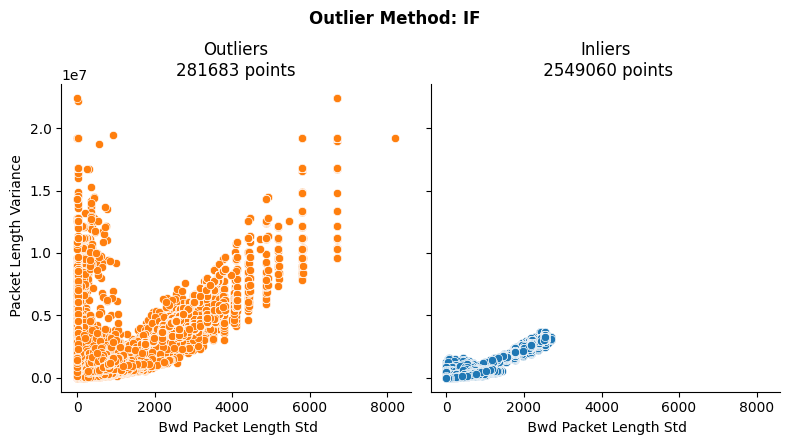

In [66]:

# Print out key statistics
print(f"Number of anomalous values {len(selected_dataset[selected_dataset['anomaly']==-1])}")
print(f"Number of non anomalous values  {len(selected_dataset[selected_dataset['anomaly']== 1])}")
print(f'Total Number of Values: {len(selected_dataset)}')

# Create the chart using seaborn
g = sns.FacetGrid(selected_dataset, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
g.map(sns.scatterplot, ' Bwd Packet Length Std', ' Packet Length Variance')
g.fig.suptitle(f'Outlier Method: IF', y=1.10, fontweight='bold')
axes = g.axes.flatten()
axes[0].set_title(f"Outliers\n{len(selected_dataset[selected_dataset['anomaly']== -1])} points")
axes[1].set_title(f"Inliers\n {len(selected_dataset[selected_dataset['anomaly']==  1])} points")